In [1]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import joblib

import statistics
from sklearn.model_selection import KFold
import time
from utils import calculate_metric

from pytorch_tabular.models import GANDALFConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig
)
from pytorch_tabular import TabularModel
import matplotlib.pyplot as plt

In [2]:
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [83]:
INPUT_FILE = "../data/data_removing_na.xlsx"
MODEL_PATH = '../output/GANDALF'
BATCH_SIZE = 32
PROJECT_NAME = "run/GANDALF"
TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "GANDALF"
OUTPUT_FILE = MODEL_PATH + '/GANDALF.pkl'

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
NO_DEVICE = 4

In [4]:
DEVICE

device(type='cpu')

In [5]:
df = pd.read_excel(INPUT_FILE)

In [6]:
df.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
0,0.259908,USD,Senior Subordinated Unsecured,9.000,United States,United States,Consumer Discretionary,Retail & Whsle - Discretionary,E-Commerce Discretionary,Bankruptcy Filing,...,0.396731,0.397453,0.398148,0.398819,0.399467,0.400092,-0.732815,-0.007137,-0.852484,False
1,0.032729,USD,Senior Subordinated Unsecured,5.750,United States,United States,Health Care,Health Care,Health Care Facilities & Svcs,Default Corp Action,...,0.957454,0.957467,0.957480,0.957492,0.957503,0.957514,-1.666262,-0.000286,-1.186347,False
2,0.972400,USD,Unsecured,5.675,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
3,1.047416,CHF,Unsecured,0.125,South Korea,South Korea,Consumer Discretionary,Retail & Whsle - Discretionary,Wholesale - Discretionary,Default Corp Action,...,0.568169,0.568693,0.569197,0.569682,0.570150,0.570600,-1.853366,0.000191,1.053677,False
4,0.848872,JPY,Unsecured,1.750,Japan,Japan,Industrials,Industrial Products,Electrical Equipment,Bankruptcy Filing,...,0.130285,0.130688,0.131081,0.131465,0.131840,0.132206,-0.768857,-0.028058,-1.946507,False


In [7]:
df.shape

(1725, 165)

In [8]:
feature_list = df.columns
feature_list = feature_list.drop('rr1_30')

In [9]:
feature_list

Index(['currency', 'seniorioty_adj', 'coupon rate', 'domicile_country',
       'exchange_country', 'Industry_sector', 'Industry_group',
       'Industry_subgroup', 'event_type', 'event_type_subcategory_sum',
       ...
       'PD_55_pd', 'PD_56_pd', 'PD_57_pd', 'PD_58_pd', 'PD_59_pd', 'PD_60_pd',
       'DTD', 'NI_Over_TA', 'Size', 'defaulted_in_last_6_months'],
      dtype='object', length=164)

In [10]:
category_features = list(df.select_dtypes(include=['object', 'bool']).columns)
non_category_features = [i for i in feature_list if i not in category_features]

In [11]:
print(len(non_category_features))
print(len(category_features))

153
11


In [12]:
category_features

['currency',
 'seniorioty_adj',
 'domicile_country',
 'exchange_country',
 'Industry_sector',
 'Industry_group',
 'Industry_subgroup',
 'event_type',
 'event_type_subcategory_sum',
 'defaulted_in_last_5_years',
 'defaulted_in_last_6_months']

In [13]:
# split data into training and test set
test_size = 0.25
train, test = train_test_split(df, test_size=test_size, random_state=42)

In [14]:
train.head()

,rr1_30,currency,seniorioty_adj,coupon rate,domicile_country,exchange_country,Industry_sector,Industry_group,Industry_subgroup,event_type,...,PD_55_pd,PD_56_pd,PD_57_pd,PD_58_pd,PD_59_pd,PD_60_pd,DTD,NI_Over_TA,Size,defaulted_in_last_6_months
755,0.082481,USD,Senior Unsecured,7.500,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.691011,0.691382,0.691738,0.692080,0.692408,0.692725,-1.084433,-0.052027,-2.074964,False
588,0.378845,USD,Unsecured,6.000,Indonesia,Indonesia,Materials,Materials,Metals & Mining,Default Corp Action,...,0.183801,0.184996,0.186167,0.187313,0.188437,0.189539,-0.540409,0.017209,0.864692,False
585,0.836149,USD,Senior Secured,11.000,United States,United States,Materials,Materials,Metals & Mining,Default Corp Action,...,0.278774,0.280216,0.281615,0.282972,0.284290,0.285571,0.754647,-0.010395,-0.342209,False
1329,0.987208,USD,Senior Secured,9.125,United States,United States,Energy,Oil & Gas,Oil & Gas Services & Equip,Default Corp Action,...,0.190375,0.191471,0.192544,0.193594,0.194622,0.195628,-0.242080,-0.022618,-2.808528,False
973,1.021458,USD,Senior Secured,9.250,United States,United States,Energy,Oil & Gas,Oil & Gas Producers,Default Corp Action,...,0.149501,0.150930,0.152327,0.153692,0.155027,0.156332,1.138686,0.000033,-0.085154,False


TUNING PARAMETERS

In [19]:
EPOCHS = 100
target_col = 'rr1_30'

data_config = DataConfig(
    target=[
        target_col
    ],  # target should always be a list
    continuous_cols=non_category_features,
    categorical_cols=category_features,
)
trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
    # devices=NO_DEVICE
)
optimizer_config = OptimizerConfig()
experiment_config = ExperimentConfig(project_name=PROJECT_NAME,exp_watch="all",log_target="tensorboard")

In [20]:
# empty cache first
torch.cuda.empty_cache()

In [21]:
def objective(trial):
    #Number of layers in the feature abstraction
    gflu_stages = trial.suggest_int("gflu_stages", 1, 10, log=True)
    
    #initial percentage of features to be selected in each GFLU stage.
    gflu_feature_init_sparsity = trial.suggest_float("gflu_feature_init_sparsity", 0.1, 1, log=True)
    gflu_dropout = trial.suggest_float("gflu_dropout", 0, 0.5)

    # Generate the optimizers.
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model_config = GANDALFConfig(
            task="regression",
            gflu_stages=gflu_stages,    #Number of layers in the feature abstraction
            gflu_feature_init_sparsity=gflu_feature_init_sparsity, #initial percentage of features to be selected in each GFLU stage.
            gflu_dropout=gflu_dropout,
            learning_rate=lr,
        )
    # Initialize the model
    tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config,
            experiment_config=experiment_config,
            verbose=True
        )

    # training with 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    datamodule = None
    model = None
    mse_scores = []

    for index, (train_idx, val_idx) in enumerate(kf.split(train)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = train.iloc[train_idx], train.iloc[val_idx]
        
        if datamodule is None:
            # Initialize datamodule and model in the first fold
            # uses train data from this fold to fit all transformers
            datamodule = tabular_model.prepare_dataloader(
                train=train_fold, validation=val_fold, seed=42
            )
            model = tabular_model.prepare_model(datamodule)
        else:
            # Creates a copy of the datamodule with same transformers but different train and validation data
            datamodule = datamodule.copy(train=train_fold, validation=val_fold)
            
        # Train the model
        tabular_model.train(model, datamodule)

        # Validation of the model.
        val_res = tabular_model.evaluate(val_fold)
        mse_scores.append(val_res[0]['test_loss'])

        trial.report(val_res[0]['test_loss'], index)

    # Return the average validation loss across all folds
    return np.mean(mse_scores)

In [22]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-04-02 16:11:45,950] A new study created in memory with name: no-name-19f929ad-709d-46af-b44c-24a9fc4269fe


2025-04-02 16:11:45,991 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-02 16:11:45,996 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 16:11:46,040 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-02 16:11:46,128 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-02 16:11:46,145 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 16:11:46,169 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 16:55:00,029 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 16:55:00,031 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06739633530378342    │
│  test_mean_squared_error  │    0.06739633530378342    │
└───────────────────────────┴───────────────────────────┘

2025-04-02 16:55:00,498 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 16:55:00,531 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 16:55:00,562 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 17:29:51,558 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 17:29:51,561 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.07441733032464981    │
│  test_mean_squared_error  │    0.07441733032464981    │
└───────────────────────────┴───────────────────────────┘

2025-04-02 17:29:52,160 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 17:29:52,199 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 17:29:52,259 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 19:33:11,577 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 19:33:11,579 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.059464070945978165    │
│  test_mean_squared_error  │   0.059464070945978165    │
└───────────────────────────┴───────────────────────────┘

2025-04-02 19:33:12,080 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 19:33:12,115 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 19:33:12,176 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 20:30:32,735 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 20:30:32,736 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05900939926505089    │
│  test_mean_squared_error  │    0.05900939926505089    │
└───────────────────────────┴───────────────────────────┘

2025-04-02 20:30:33,318 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 20:30:33,359 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 20:30:33,416 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 20:35:39,193 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 20:35:39,196 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06223229691386223    │
│  test_mean_squared_error  │    0.06223229691386223    │
└───────────────────────────┴───────────────────────────┘

[I 2025-04-02 20:35:40,118] Trial 0 finished with value: 0.0645038865506649 and parameters: {'gflu_stages': 9, 'gflu_feature_init_sparsity': 0.1950409583306746, 'gflu_dropout': 0.030707294595931856, 'learning_rate': 0.015269936277354889}. Best is trial 0 with value: 0.0645038865506649.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.0645038865506649
  Params: 
    gflu_stages: 9
    gflu_feature_init_sparsity: 0.1950409583306746
    gflu_dropout: 0.030707294595931856
    learning_rate: 0.015269936277354889


In [38]:
trial.params

{'gflu_stages': 9,
 'gflu_feature_init_sparsity': 0.1950409583306746,
 'gflu_dropout': 0.030707294595931856,
 'learning_rate': 0.015269936277354889}

In [24]:
best_param = trial.params

In [39]:
# best_param = {'gflu_stages': 1,
#  'gflu_feature_init_sparsity': 0.7517028756773947,
#  'gflu_dropout': 0.310129872375981,
#  'learning_rate': 0.011357265478429133}

RUNNING THE MODEL

In [47]:
# empty cache first
torch.cuda.empty_cache()

In [87]:
EPOCHS = 500

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None,
    # devices=NO_DEVICE
)


model_config = GANDALFConfig(
    **best_param,
    task="regression",
    metrics=["mean_absolute_error", "mean_absolute_percentage_error", "mean_squared_error", "r2_score"]
)


In [88]:
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

In [89]:
tabular_model.fit(train=train) #validation=test) #by default, it takes 20% of the data as validation to select the best epoch

Seed set to 42


2025-04-03 13:40:00,089 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-03 13:40:00,097 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-03 13:40:00,149 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-03 13:40:00,230 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-03 13:40:00,252 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-03 13:40:00,311 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.5 K │ train │
│ 2 │ _head            │ Sequential       │    240 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=500` reached.


2025-04-03 14:24:39,756 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-03 14:24:39,757 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

In [92]:
train_predictions = tabular_model.predict(train)
 # save metrics
mae, mape, rmse, rsqr = calculate_metric(train_predictions.to_numpy().squeeze(), train[target_col].to_numpy())
print(f"Training average mean absolute error: {mae}")
print(f"Training average mean absolute percentage error: {mape}")
print(f"Training average root mean squared error: {rmse}")
print(f"Training average R2: {rsqr}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

Training average mean absolute error: 0.14006847615415205
Training average mean absolute percentage error: 1254.743243879854
Training average root mean squared error: 0.18863523341516827
Training average R2: 0.6720055956244722


In [91]:
predictions = tabular_model.predict(test)

 # save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions.to_numpy().squeeze(), test[target_col].to_numpy())
print(f"Test average mean absolute error: {mae}")
print(f"Test average mean absolute percentage error: {mape}")
print(f"Test average root mean squared error: {rmse}")
print(f"Test average R2: {rsqr}")

Test average mean absolute error: 0.18670513284627022
Test average mean absolute percentage error: 226.68321401912812
Test average root mean squared error: 0.24760712207115046
Test average R2: 0.4647533636323422


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

In [93]:
# save train predictions
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    predictions.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(tabular_model, OUTPUT_FILE)

['../output/GANDALF/GANDALF.pkl']

In [94]:
tabular_model

Layer,Type,Params,In sizes,Out sizes
_backbone,GANDALFBackbone,3067353,?,?
_embedding_layer,Embedding1dLayer,2485,?,?
_head,Sequential,240,?,?
loss,MSELoss,0,?,?


In [95]:
native_ft_importance = tabular_model.feature_importance().sort_values("importance", ascending=False)
native_ft_importance

,Features,importance
76,operating_margin,1.072724e+00
144,PD_44_pd,1.072026e+00
84,dtd_sector_median,9.999988e-01
95,3_month_financial_certainty,9.999986e-01
124,PD_24_pd,9.611146e-01
...,...,...
62,1-year_M2_growth,3.556864e-08
32,PD_1_domicile_sector,3.553062e-08
71,relative_size,3.538547e-08
130,PD_30_pd,3.517459e-08


<Figure size 1400x600 with 0 Axes>

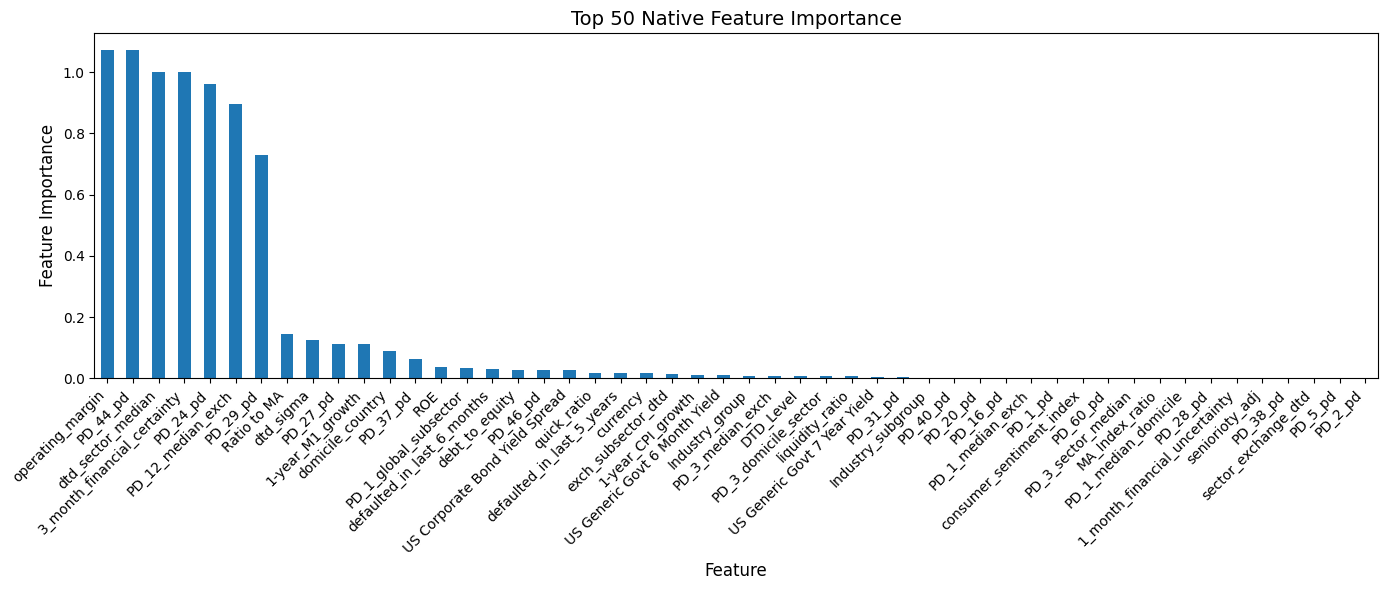

In [96]:
# Select the top 50 features
top_native_features = native_ft_importance.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_native_features.plot(
    kind="bar", x="Features", y="importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Native Feature Importance", fontsize=14)
plt.ylabel("Feature Importance", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

plt.savefig(f"{MODEL_PATH}/native_feature_importance.png")

# Show the plot
plt.show()

SHAP on training set

In [97]:
# Explain a single instance using the GradientShap method and baseline as 10000 samples from the training data
kernelSHAP = tabular_model.explain(train, method="KernelShap", baselines="b|1000")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/tabular_model.py:2020: UserWarning: KernelShap is computationally expensive and will take some time. For faster results, try usingsome other methods like GradientShap, IntegratedGradients etc.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Libr

In [98]:
feature_importance = kernelSHAP.abs().median().sort_values(ascending=False)
feature_importance

Industry_subgroup             0.031180
coupon rate                   0.016250
domicile_country              0.014717
Industry_group                0.012699
event_type_subcategory_sum    0.011254
                                ...   
PD_2_pd                       0.002339
PD_52_pd                      0.002334
PD_17_pd                      0.002280
current ratio                 0.002261
PD_1_pd                       0.002258
Length: 164, dtype: float32

In [99]:
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ["Feature", "Importance"]

<Figure size 1400x600 with 0 Axes>

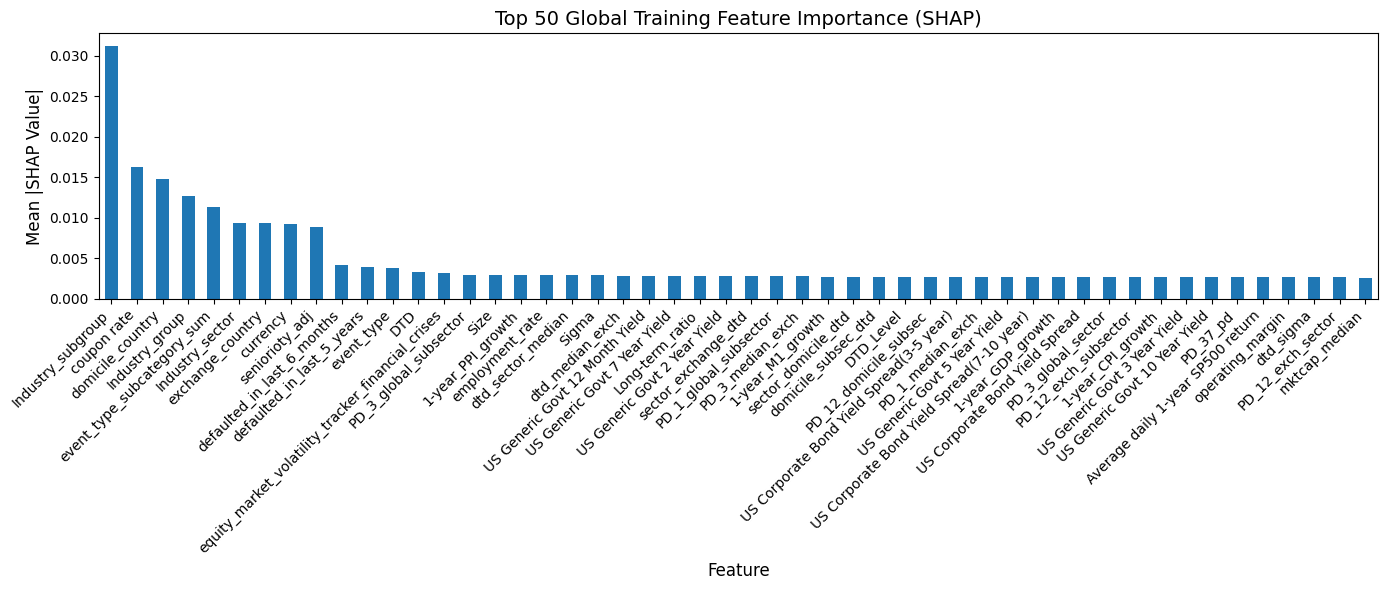

In [100]:
# Select the top 50 features
top_features = feature_importance_df.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_features.plot(
    kind="bar", x="Feature", y="Importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Global Training Feature Importance (SHAP)", fontsize=14)
plt.ylabel("Mean |SHAP Value|", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

# save the fig
plt.savefig(f"{MODEL_PATH}/training_shap.png")

# Show the plot
plt.show()

SHAP on test set

In [101]:
# Explain a single instance using the GradientShap method and baseline as 10000 samples from the training data
kernelSHAP = tabular_model.explain(test, method="KernelShap", baselines="b|1000")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/tabular_model.py:2020: UserWarning: KernelShap is computationally expensive and will take some time. For faster results, try usingsome other methods like GradientShap, IntegratedGradients etc.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Libr

In [102]:
feature_importance = kernelSHAP.abs().median().sort_values(ascending=False)

In [103]:
feature_importance

Industry_subgroup                0.027985
coupon rate                      0.014894
domicile_country                 0.013739
Industry_group                   0.013056
event_type_subcategory_sum       0.011633
                                   ...   
PD_51_pd                         0.002289
PD_39_pd                         0.002273
PD_3_domicile_subsec             0.002265
PD_13_pd                         0.002240
shares_out_outstanding_shares    0.002131
Length: 164, dtype: float32

In [104]:
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ["Feature", "Importance"]

<Figure size 1400x600 with 0 Axes>

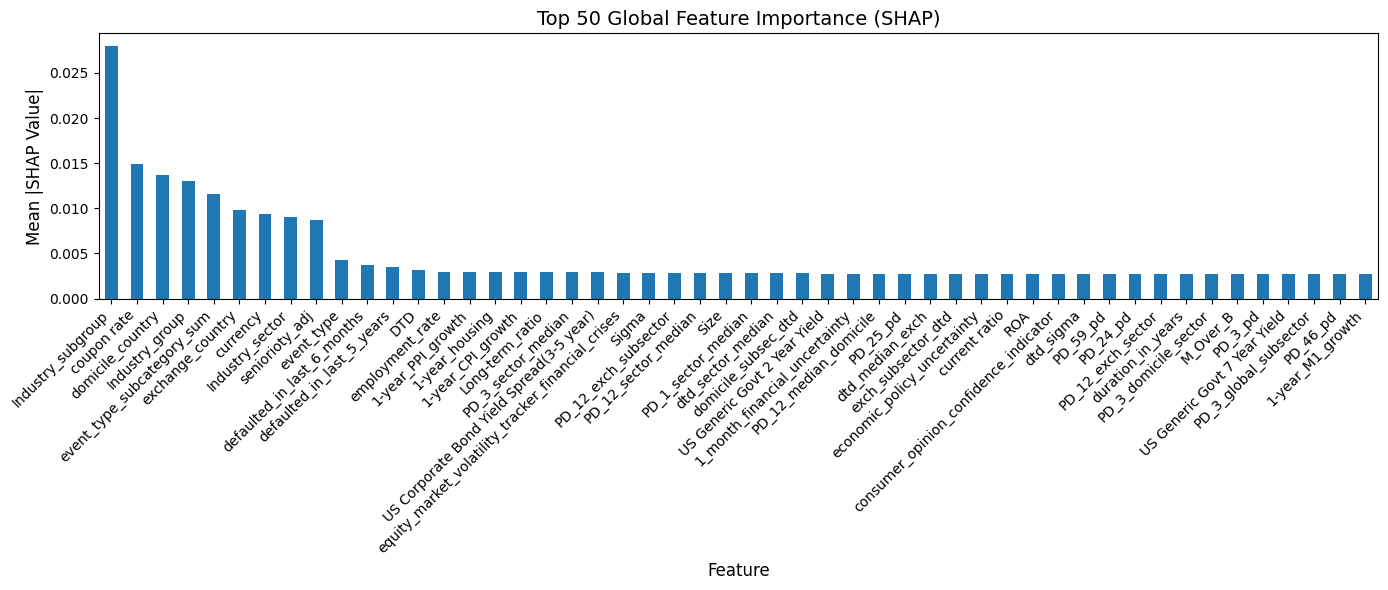

In [105]:
# Select the top 50 features
top_features = feature_importance_df.head(50)

# Set a larger figure size
plt.figure(figsize=(14, 6))

# Create the bar plot for top 50 features
top_features.plot(
    kind="bar", x="Feature", y="Importance", legend=False, figsize=(14, 6)
)

# Add title and labels
plt.title("Top 50 Global Feature Importance (SHAP)", fontsize=14)
plt.ylabel("Mean |SHAP Value|", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Adjust layout to prevent label overlap
plt.tight_layout()

# save the fig
plt.savefig(f"{MODEL_PATH}/testing_shap.png")

# Show the plot
plt.show()

5 fold CV

In [65]:
# Define cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
EPOCHS = 100
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=True
)

trainer_config = TrainerConfig(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS,
    early_stopping=None
)

model = None
datamodule = None

for index, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Create training and validation datasets for the current fold
        train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
        
        if datamodule is None:
            # Initialize datamodule and model in the first fold
            # uses train data from this fold to fit all transformers
            datamodule = tabular_model.prepare_dataloader(
                train=train_fold, validation=val_fold, seed=42
            )
            model = tabular_model.prepare_model(datamodule)
        else:
            # Creates a copy of the datamodule with same transformers but different train and validation data
            datamodule = datamodule.copy(train=train_fold, validation=val_fold)
            
        # Train the model
        tabular_model.train(model, datamodule)
        pred_df = tabular_model.predict(val_fold)

        # Validation of the model.
        mae, mape, rmse, rsqr = calculate_metric(pred_df.to_numpy().squeeze(), val_fold[target_col].to_numpy())
        val_mae.append(mae)
        val_mape.append(mape)
        val_rmse.append(rmse)
        val_rsqr.append(rsqr)

2025-04-02 21:38:26,156 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-04-02 21:38:26,170 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 21:38:26,228 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-04-02 21:38:26,314 - {pytorch_tabular.models.gandalf.gandalf:109} - INFO - Data Aware Initialization of T0

2025-04-02 21:38:26,339 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 21:38:26,410 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.2 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 21:47:10,625 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 21:47:10,628 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-02 21:47:10,779 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 21:47:10,830 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 21:47:10,918 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.2 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 21:55:21,914 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 21:55:21,918 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-02 21:55:22,786 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 21:55:22,918 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 21:55:23,004 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.2 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 22:01:57,009 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 22:01:57,011 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-02 22:01:57,224 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 22:01:57,275 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 22:01:57,363 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.2 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 22:08:27,911 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 22:08:27,913 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

2025-04-02 22:08:28,054 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

2025-04-02 22:08:28,106 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-04-02 22:08:28,272 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/Code/final/src/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  3.2 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │  2.8 K │ train │
│ 2 │ _head            │ Sequential       │    245 │ train │
│ 3 │ loss             │ MSELoss          │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 44                                                                                          
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-04-02 22:15:01,006 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-04-02 22:15:01,008 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabular/utils/python_utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retur

In [66]:
val_rmse

[0.25126535714794607,
 0.2764848270500592,
 0.26554510290169747,
 0.25295804977273684,
 0.25355956185866046]

In [68]:
print(f"Test average mean absolute error: {statistics.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {statistics.mean(val_mape)}")
print(f"Test average root mean squared error: {statistics.mean(val_rmse)}")
print(f"Test average R2: {statistics.mean(val_rsqr)}")

Test average mean absolute error: 0.20752070409932585
Test average mean absolute percentage error: 4303.927084526877
Test average root mean squared error: 0.25996257974622
Test average R2: 0.3821694749020563
